In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 查看数据 

In [2]:
data = pd.read_csv('../data/train/train.csv')
data.head(5)

id_num program_type program_id  program_duration  test_id test_type  \
0   9389_150            Y        Y_1             136.0    150.0   offline   
1   16523_44            T        T_1             131.0     44.0   offline   
2  13987_178            Z        Z_2             120.0    178.0    online   
3   13158_32            T        T_2             117.0     32.0   offline   
4   10591_84            V        V_3             131.0     84.0   offline   

  difficulty_level  trainee_id gender            education  city_tier   age  \
0     intermediate      9389.0      M        Matriculation        3.0  24.0   
1             easy     16523.0      F  High School Diploma        4.0  26.0   
2             easy     13987.0      M        Matriculation        1.0  40.0   
3             easy     13158.0      F        Matriculation        3.0   NaN   
4     intermediate     10591.0      F  High School Diploma        1.0  42.0   

   total_programs_enrolled is_handicapped  trainee_engagement_rating  is_pass  
0                      5.0              N                        1.0        0  
1                      2.0              N                        3.0        1  
2                      1.0              N                        2.0        1  
3                      4.0              N                        1.0        1  
4                      2.0              N                        4.0        1

预测is_pass，**是二元分类问题**，打算采取逻辑回归算法

<AxesSubplot:>

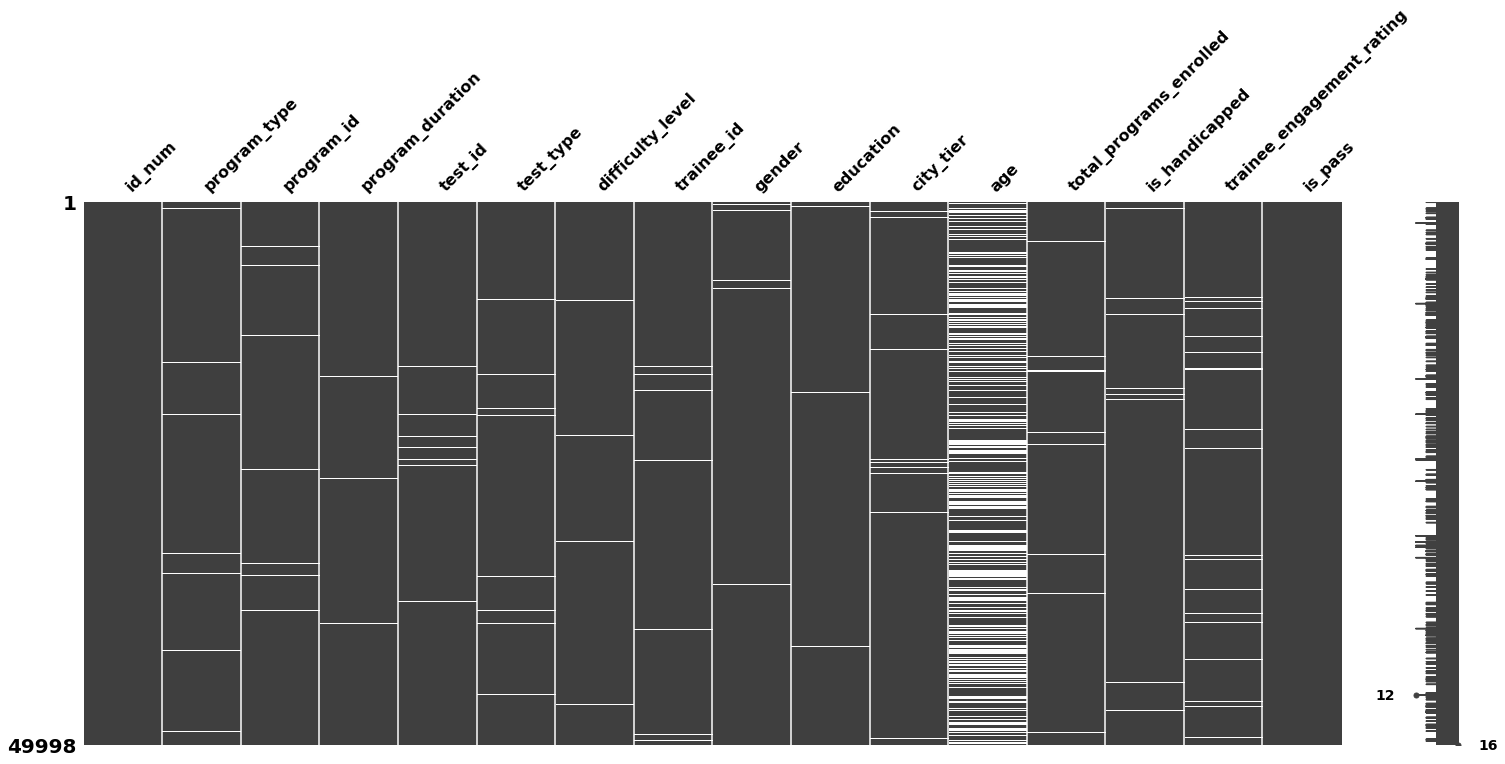

In [6]:
# 利用missingno库可视化缺失值情况
msno.matrix(data)

**白线越多，缺失值越多**，再次说明了其余都是个别有缺失值，age则是大部分。

In [7]:
# 绘制热力图，查看缺失值间关系
msno.heatmap(data)

<AxesSubplot:>

图表明缺失值间出现没有相关性

# 缺失值处理

缺失值如果是**数值型特征**，可以考虑**用平均值填充**。如果是字符串型特征，可以考虑删除该项id。上限：0.70883

新的思考角度：可以用其他特征来预测缺失值，如果是数值型特征用线性回归，分类型特征用逻辑回归。（做了之后并不觉得可行）

In [8]:
# 对年龄和程序持续时间的缺失值进行填充
data['age'] = data['age'].fillna(data['age'].mean())
data['program_duration'] = data['program_duration'].fillna(data['program_duration'].mean())
data.isnull().sum() 

id_num                         0
program_type                 731
program_id                   699
program_duration               0
test_id                      725
test_type                    702
difficulty_level             703
trainee_id                   739
gender                       707
education                    702
city_tier                    700
age                            0
total_programs_enrolled      692
is_handicapped               718
trainee_engagement_rating    772
is_pass                        0
dtype: int64

In [9]:
# 其他特征如果有缺失则删除，因为其他特征是用于分类，分错类会产生误导
orilen = len(data.index)
data = data.dropna()
aftlen = len(data.index)
print('共删去%d条数据' % (orilen-aftlen))

共删去7954条数据


# 特征离散化

In [10]:
data['test_type'].unique()

array(['offline', 'online'], dtype=object)

In [11]:
test_type_mapping = {
    'offline': 0,
    'online': 1
}
data['test_type'] = data['test_type'].map(test_type_mapping)

In [12]:
data['gender'].unique()

array(['M', 'F'], dtype=object)

In [13]:
gender_mapping = {
    'M': 0,
    'F': 1
}
data['gender'] = data['gender'].map(gender_mapping)

In [14]:
data['education'].unique()

array(['Matriculation', 'High School Diploma', 'Bachelors', 'Masters',
       'No Qualification'], dtype=object)

In [15]:
education_mapping = {
    'No Qualification': 1,
    'High School Diploma': 2,
    'Matriculation': 3,
    'Bachelors': 4,
    'Masters': 5
}
data['education'] = data['education'].map(education_mapping)

In [16]:
data['difficulty_level'].unique()

array(['intermediate', 'easy', 'hard', 'vary hard'], dtype=object)

In [17]:
difficulty_mapping = {
    'easy': 1,
    'intermediate': 2,
    'hard': 3,
    'vary hard': 4
}
data['difficulty_level'] = data['difficulty_level'].map(difficulty_mapping)

In [18]:
data['is_handicapped'].unique()

array(['N', 'Y'], dtype=object)

In [19]:
handicap_mapping = {
    'N': 0,
    'Y': 1
}
data['is_handicapped'] = data['is_handicapped'].map(handicap_mapping)

# 特征工程

In [20]:
# 查看系数矩阵
data.corr()
# 可看出test_type，age，trainee_engagement_rating与is_pass有较强的相关性

program_duration   test_id  test_type  \
program_duration                   1.000000  0.210907  -0.070053   
test_id                            0.210907  1.000000   0.190091   
test_type                         -0.070053  0.190091   1.000000   
difficulty_level                   0.097100 -0.038605  -0.650012   
trainee_id                         0.150775  0.144733  -0.028770   
gender                            -0.112783 -0.283271   0.001955   
education                          0.011974 -0.007677  -0.005832   
city_tier                         -0.021764 -0.002590   0.009809   
age                               -0.016841 -0.019973   0.035569   
total_programs_enrolled           -0.010975 -0.135756  -0.026732   
is_handicapped                    -0.009010  0.025121   0.008983   
trainee_engagement_rating          0.096159  0.319119   0.110723   
is_pass                            0.004507  0.075874   0.153532   

                           difficulty_level  trainee_id    gender  education  \
program_duration                   0.097100    0.150775 -0.112783   0.011974   
test_id                           -0.038605    0.144733 -0.283271  -0.007677   
test_type                         -0.650012   -0.028770  0.001955  -0.005832   
difficulty_level                   1.000000    0.030420 -0.135104   0.010128   
trainee_id                         0.030420    1.000000 -0.016233   0.037000   
gender                            -0.135104   -0.016233  1.000000  -0.052504   
education                          0.010128    0.037000 -0.052504   1.000000   
city_tier                         -0.032139   -0.013060  0.066225  -0.040285   
age                               -0.022557    0.084301  0.016554   0.142722   
total_programs_enrolled            0.061159   -0.077317 -0.060755  -0.036910   
is_handicapped                    -0.028147   -0.023383  0.049000  -0.046840   
trainee_engagement_rating          0.100371    0.022830 -0.273128   0.049616   
is_pass                           -0.111766    0.036347 -0.023127   0.002989   

                           city_tier       age  total_programs_enrolled  \
program_duration           -0.021764 -0.016841                -0.010975   
test_id                    -0.002590 -0.019973                -0.135756   
test_type                   0.009809  0.035569                -0.026732   
difficulty_level           -0.032139 -0.022557                 0.061159   
trainee_id                 -0.013060  0.084301                -0.077317   
gender                      0.066225  0.016554                -0.060755   
education                  -0.040285  0.142722                -0.036910   
city_tier                   1.000000 -0.061970                 0.014948   
age                        -0.061970  1.000000                -0.053579   
total_programs_enrolled     0.014948 -0.053579                 1.000000   
is_handicapped              0.058205 -0.027144                 0.034306   
trainee_engagement_rating  -0.057836  0.150337                 0.085228   
is_pass                    -0.069143  0.057903                -0.032493   

                           is_handicapped  trainee_engagement_rating   is_pass  
program_duration                -0.009010                   0.096159  0.004507  
test_id                          0.025121                   0.319119  0.075874  
test_type                        0.008983                   0.110723  0.153532  
difficulty_level                -0.028147                   0.100371 -0.111766  
trainee_id                      -0.023383                   0.022830  0.036347  
gender                           0.049000                  -0.273128 -0.023127  
education                       -0.046840                   0.049616  0.002989  
city_tier                        0.058205                  -0.057836 -0.069143  
age                             -0.027144                   0.150337  0.057903  
total_programs_enrolled          0.034306                   0.085228 -0.032493  
is_handicap

In [21]:
# 先删去无用的特征
data = data.drop(['id_num', 'program_type', 'test_id', 'trainee_id'], axis=1)

trainee_id和test_id为**无序的离散值**,我考虑直接删除掉。而programme_type和programme_id有一定的顺序规律，对is_pass有影响，又因为programe_id值也表明了programe_type的身份（例Y_1表明了他programe_type为Y），所以可以删去programe_type，**用独热编码来表达programe_id**。

In [22]:
data.head(5)

program_id  program_duration  test_type  difficulty_level  gender  \
0        Y_1             136.0          0                 2       0   
1        T_1             131.0          0                 1       1   
2        Z_2             120.0          1                 1       0   
3        T_2             117.0          0                 1       1   
4        V_3             131.0          0                 2       1   

   education  city_tier        age  total_programs_enrolled  is_handicapped  \
0          3        3.0  24.000000                      5.0               0   
1          2        4.0  26.000000                      2.0               0   
2          3        1.0  40.000000                      1.0               0   
3          3        3.0  36.514256                      4.0               0   
4          2        1.0  42.000000                      2.0               0   

   trainee_engagement_rating  is_pass  
0                        1.0        0  
1                        3.0        1  
2                        2.0        1  
3                        1.0        1  
4                        4.0        1

In [23]:
program_id_onehot = pd.get_dummies(data['program_id'])
onehoted = pd.concat([data, program_id_onehot], axis=1)
onehoted = onehoted.drop('program_id', axis=1)

In [24]:
onehoted.head(5)

program_duration  test_type  difficulty_level  gender  education  \
0             136.0          0                 2       0          3   
1             131.0          0                 1       1          2   
2             120.0          1                 1       0          3   
3             117.0          0                 1       1          3   
4             131.0          0                 2       1          2   

   city_tier        age  total_programs_enrolled  is_handicapped  \
0        3.0  24.000000                      5.0               0   
1        4.0  26.000000                      2.0               0   
2        1.0  40.000000                      1.0               0   
3        3.0  36.514256                      4.0               0   
4        1.0  42.000000                      2.0               0   

   trainee_engagement_rating  ...  X_1  X_2  X_3  Y_1  Y_2  Y_3  Y_4  Z_1  \
0                        1.0  ...    0    0    0    1    0    0    0    0   
1                        3.0  ...    0    0    0    0    0    0    0    0   
2                        2.0  ...    0    0    0    0    0    0    0    0   
3                        1.0  ...    0    0    0    0    0    0    0    0   
4                        4.0  ...    0    0    0    0    0    0    0    0   

   Z_2  Z_3  
0    0    0  
1    0    0  
2    1    0  
3    0    0  
4    0    0  

[5 rows x 33 columns]

# 归一化

program_duration和age需进行归一化

In [25]:
onehoted.loc[:, 'age'] /= onehoted['age'].mean()
onehoted.loc[:, 'program_duration'] /= onehoted['program_duration'].mean()
onehoted.head(5)
# 完成归一化

program_duration  test_type  difficulty_level  gender  education  \
0          1.060738          0                 2       0          3   
1          1.021740          0                 1       1          2   
2          0.935945          1                 1       0          3   
3          0.912547          0                 1       1          3   
4          1.021740          0                 2       1          2   

   city_tier       age  total_programs_enrolled  is_handicapped  \
0        3.0  0.657070                      5.0               0   
1        4.0  0.711826                      2.0               0   
2        1.0  1.095117                      1.0               0   
3        3.0  0.999685                      4.0               0   
4        1.0  1.149873                      2.0               0   

   trainee_engagement_rating  ...  X_1  X_2  X_3  Y_1  Y_2  Y_3  Y_4  Z_1  \
0                        1.0  ...    0    0    0    1    0    0    0    0   
1                        3.0  ...    0    0    0    0    0    0    0    0   
2                        2.0  ...    0    0    0    0    0    0    0    0   
3                        1.0  ...    0    0    0    0    0    0    0    0   
4                        4.0  ...    0    0    0    0    0    0    0    0   

   Z_2  Z_3  
0    0    0  
1    0    0  
2    1    0  
3    0    0  
4    0    0  

[5 rows x 33 columns]

# 算法拟合

In [26]:
from LogisticRegression import LogisticRegression # 自己写的逻辑回归
from Evaluate import accuracy
from sklearn.model_selection import KFold

In [27]:
kf = KFold(n_splits=5,shuffle=True)

In [28]:
lr = LogisticRegression(times=1000,alpha=0.1)
thetas = [] # 存放k折验证每一次的theta
corrects = [] # 存放准确率

In [29]:
X = onehoted.drop('is_pass', axis=1)
Y = onehoted['is_pass']

### 用两种分割数据集的方法进行测试，选择效果最好的theta

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2)
lr.fit(x_train, y_train)
thetas.append(lr.theta)

In [31]:
ypre = lr.predict(x_test)
correct = accuracy(ypre, y_test)
corrects.append(correct)
print(correct)

0.719705077892734


In [32]:
for train_index, test_index in kf.split(X):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    lr.fit(x_train, y_train)
    thetas.append(lr.theta)
    y_pre = lr.predict(x_test)
    correct = accuracy(y_test, y_pre)
    corrects.append(correct)
    print('准确率为:%f' % correct)

准确率为:0.709835
准确率为:0.713164
准确率为:0.710191
准确率为:0.709954
准确率为:0.711108


In [33]:
best_index = corrects.index(max(corrects))
best_theta = thetas[best_index]
print('准确率最高的theta为第%d个' % (best_index+1))

准确率最高的theta为第1个


# 预测test1

In [34]:
# 导入test文件
test1 = pd.read_csv('../data/test/test1.csv')

In [35]:
test1.head(5)

id_num program_type program_id  program_duration  test_id test_type  \
0  1442_124            Y        Y_4               121      124    online   
1  12373_38            T        T_2               117       38    online   
2  12035_21            T        T_3               134       21   offline   
3  11148_86            V        V_3               131       86   offline   
4  1362_131            Y        Y_3               135      131    online   

  difficulty_level  trainee_id gender            education  city_tier   age  \
0             easy        1442      M  High School Diploma          2   NaN   
1             easy       12373      F  High School Diploma          4  31.0   
2             easy       12035      F  High School Diploma          4   NaN   
3        vary hard       11148      M        Matriculation          1   NaN   
4             easy        1362      M  High School Diploma          2  45.0   

   total_programs_enrolled is_handicapped  trainee_engagement_rating  is_pass  
0                        8              N                        4.0      NaN  
1                        2              N                        3.0      NaN  
2                        2              N                        1.0      NaN  
3                        2              N                        1.0      NaN  
4                        2              N                        4.0      NaN

In [36]:
test1.isnull().sum()

id_num                           0
program_type                     0
program_id                       0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                           4400
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating       11
is_pass                      11684
dtype: int64

In [37]:
# 缺失值处理
test1['age'] = test1['age'].fillna(test1['age'].mean())
test1['trainee_engagement_rating'] = test1['trainee_engagement_rating'].fillna(test1['trainee_engagement_rating'].mean())

In [38]:
# 特征离散化
test1['test_type'] = test1['test_type'].map(test_type_mapping)
test1['gender'] = test1['gender'].map(gender_mapping)
test1['education'] = test1['education'].map(education_mapping)
test1['difficulty_level'] = test1['difficulty_level'].map(difficulty_mapping)
test1['is_handicapped'] = test1['is_handicapped'].map(handicap_mapping)

In [39]:
# 删除无用特征
record = test1['id_num'] # 记录下id_num
test1 = test1.drop(['id_num', 'program_type', 'test_id', 'trainee_id', 'is_pass'], axis=1)

# 对program_id进行独热编码，拼接到原矩阵，删除原program_id特征
test1_program_id_onehot = pd.get_dummies(test1['program_id'])
test1_onehoted = pd.concat([test1, test1_program_id_onehot], axis=1)
test1_onehoted = test1_onehoted.drop('program_id', axis=1)

# 归一化
test1_onehoted.loc[:, 'age'] /= test1_onehoted['age'].mean()
test1_onehoted.loc[:, 'program_duration'] /= test1_onehoted['program_duration'].mean()

**进行预测**

In [40]:
X_test = np.array(test1_onehoted.astype(float))

# 将best_theta设置为模型当前的theta，随后进行预测
lr.theta = best_theta
y_pre = lr.predict(X_test)

In [41]:
submit = pd.DataFrame(y_pre)
submission = pd.concat([record, submit], axis=1) # record记录着原来的id_num
submission.columns = ['id_num', 'is_pass']

In [42]:
# submission.to_csv('sub_2ways_4KFold_1k_alpha0.25.csv', index=False)

# 预测test2

In [43]:
# 导入test文件
test2 = pd.read_csv('../data/test/test2.csv')
test2.head(5)

id_num program_type program_id  program_duration  test_id test_type  \
0    4753_31            T        T_3               134       31    online   
1  10816_148            Y        Y_2               120      148    online   
2   7498_114            Y        Y_4               121      114   offline   
3  14139_175            Z        Z_2               120      175    online   
4   11305_25            T        T_3               134       25   offline   

  difficulty_level  trainee_id gender            education  city_tier   age  \
0             easy        4753      F            Bachelors          1  31.0   
1             easy       10816      M        Matriculation          3   NaN   
2     intermediate        7498      M  High School Diploma          1   NaN   
3             easy       14139      F  High School Diploma          1  44.0   
4     intermediate       11305      M  High School Diploma          2  49.0   

   total_programs_enrolled is_handicapped  trainee_engagement_rating  is_pass  
0                        4              N                        2.0      NaN  
1                        2              N                        4.0      NaN  
2                        3              N                        1.0      NaN  
3                        1              Y                        1.0      NaN  
4                        2              N                        2.0      NaN

In [44]:
test2.isnull().sum()

id_num                           0
program_type                     0
program_id                       0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                           4397
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating       14
is_pass                      11465
dtype: int64

In [45]:
# 缺失值处理
test2['age'] = test2['age'].fillna(test2['age'].mean())
test2['trainee_engagement_rating'] = test2['trainee_engagement_rating'].fillna(test2['trainee_engagement_rating'].mean())

In [46]:
# 特征离散化
test2['test_type'] = test2['test_type'].map(test_type_mapping)
test2['gender'] = test2['gender'].map(gender_mapping)
test2['education'] = test2['education'].map(education_mapping)
test2['difficulty_level'] = test2['difficulty_level'].map(difficulty_mapping)
test2['is_handicapped'] = test2['is_handicapped'].map(handicap_mapping)

In [47]:
# 删除无用特征
record2 = test2['id_num'] # 记录下id_num
test2 = test2.drop(['id_num', 'program_type', 'test_id', 'trainee_id', 'is_pass'], axis=1)

# 对program_id进行独热编码，拼接到原矩阵，删除原program_id特征
test2_program_id_onehot = pd.get_dummies(test2['program_id'])
test2_onehoted = pd.concat([test2, test2_program_id_onehot], axis=1)
test2_onehoted = test2_onehoted.drop('program_id', axis=1)

# 归一化
test2_onehoted.loc[:, 'age'] /= test2_onehoted['age'].mean()
test2_onehoted.loc[:, 'program_duration'] /= test2_onehoted['program_duration'].mean()

In [48]:
test2_onehoted

program_duration  test_type  difficulty_level  gender  education  \
0              1.045413          1                 1       1          4   
1              0.936190          1                 1       0          3   
2              0.943992          0                 2       0          2   
3              0.936190          1                 1       1          2   
4              1.045413          0                 2       0          2   
...                 ...        ...               ...     ...        ...   
11460          0.943992          0                 3       0          3   
11461          1.022008          0                 1       1          2   
11462          1.053214          1                 1       0          3   
11463          1.014206          1                 1       1          3   
11464          0.951793          0                 1       0          2   

       city_tier       age  total_programs_enrolled  is_handicapped  \
0              1  0.852766                        4               0   
1              3  1.000000                        2               0   
2              1  1.000000                        3               0   
3              1  1.210378                        1               1   
4              2  1.347921                        2               0   
...          ...       ...                      ...             ...   
11460          3  1.000000                        1               0   
11461          3  1.265395                        4               0   
11462          4  0.687715                        2               0   
11463          4  1.100343                        1               0   
11464          2  1.000000                        3               0   

       trainee_engagement_rating  ...  X_1  X_2  X_3  Y_1  Y_2  Y_3  Y_4  Z_1  \
0                            2.0  ...    0    0    0    0    0    0    0    0   
1                            4.0  ...    0    0    0    0    1    0    0    0   
2                            1.0  ...    0    0    0    0    0    0    1    0   
3                            1.0  ...    0    0    0    0    0    0    0    0   
4                            2.0  ...    0    0    0    0    0    0    0    0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11460                        2.0  ...    0    1    0    0    0    0    0    0   
11461                        3.0  ...    0    0    0    0    0    0    0    0   
11462                        4.0  ...    0    0    0    0    0    1    0    0   
11463                        3.0  ...    0    0    0    0    0    0    0    0   
11464                        2.0  ...    0    0    0    0    0    0    0    0   

       Z_2  Z_3  
0        0    0  
1        0    0  
2        0    0  
3        1    0  
4        0    0  
...    ...  ...  
11460    0    0  
11461    0    0  
11462    0    0  
11463    0    1  
11464    0    0  

[11465 rows x 32 columns]

**进行预测**

In [49]:
X_test2 = np.array(test2_onehoted.astype(float))

# 将best_theta设置为模型当前的theta，随后进行预测
lr.theta = best_theta
y_pre2 = lr.predict(X_test2)

In [50]:
submit2 = pd.DataFrame(y_pre2)
submission2 = pd.concat([record2, submit2], axis=1) # record记录着原来的id_num
submission2.columns = ['id_num', 'is_pass']

In [51]:
# submission2.to_csv('sub6_2ways_5KFold_1k_alpha0.25.csv', index=False)